# [Kaggle Instacart Competition page](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data)

[데이터 설명]
- 이 데이터셋은 **시간**에 따른 **고객 주문**을 설명하는 csv 파일들로 구성되어 있습니다.

- 이 데이터는 사용자가 **다음 주문에 포함할 제품들을 예측**하는 것입니다. 즉, **어떤 물품을 다시 주문할지 예측**하는 문제를 풀어야 합니다.

- 데이터셋은 **익명화**되어 있으며 20만 명이 넘는 instacart 사용자의 300만건 이상의 주문들을 포함하고 있습니다.

- 각 사용자별로, 4회에서 100회 사이의 주문 데이터가 제공됩니다. 또한 주문이 이루어진 주와 시간, 그리고 주문 간의 상대적인 시간을 제공합니다.

- 데이터 파일은 6개로 구성되어 있으며, 각 csv 파일에 대한 설명은 다음과 같습니다.

각 csv파일들(customer, product, order, aisle, etc.)은 각자의 unique id를 포함하고 있습니다. 각 파일들의 대한 설명을 csv파일 이름과 column 이름을 읽으면 이해 가능한 수준입니다.

[csv별 설명]
1. aisle.csv - 아이템 중분류

2. department.csv - 아이템 대분류

3. orders.csv - 각 주문 내역들에 대한 정보

4. order_products__*.csv - 모든 고객의 이전 주문 내용이 포함되어 있습니다. 'reordered' column은 어떤 고객이 과거에 구매여부를 의미합니다. 일부 주문에는 reordered 품목이 없을 수 있습니다. reordered 품목이 없는 주문의 경우 명시적으로 '없음' 값을 예측할 수 있습니다.

5. products.csv - 각 아이템들에 대한 정보

[데이터 설명 포스트]
- [Instacart Data description](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

- [Instacart Data Dictionary](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

## Import Library

In [1]:
import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#지수표현식 없애기 
pd.options.display.float_format = '{:.0f}'.format

#되돌리기
# pd.reset_option('display.float_format')

## Logger Settings

In [2]:
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(stream_handler)

## Load Dataset

In [3]:
IS_RUNNING_ON_LOCAL = True

if IS_RUNNING_ON_LOCAL:
    data_path = "./dataset/"
else:
    data_path = '../working/data/'

In [19]:
if not IS_RUNNING_ON_LOCAL:
    import os
    import glob
    import zipfile

    # zip 압축 해제하기
    for file in glob.glob(os.path.join('../input/', "*.zip"), recursive=True):
        with zipfile.ZipFile(file) as zip:
            zip.extractall(path='../working/data/')

In [4]:
# 구매자군의 과거 제품주문내역
logger.info('loading prior')
prior = pd.read_csv(data_path + 'order_products__prior.csv', low_memory=False, dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

# 구매자군의 현재 제품주문내역
logger.info('loading train')
train = pd.read_csv(data_path + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

# 주문 정보 (각 주문 내역들에 대한 정보)
logger.info('loading orders')
orders = pd.read_csv(filepath_or_buffer=data_path + 'orders.csv', low_memory=False, dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': str,
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

# 제품 정보 (각 아이템들에 대한 정보)
logger.info('loading products')
products = pd.read_csv(data_path + 'products.csv', dtype={
        'product_id': np.uint16,
        'aisle_id': np.uint8,
        'department_id': np.uint8})

# 제품 상세 카테고리 (아이템 중분류)
logger.info('loading aisles')
aisles = pd.read_csv(data_path + 'aisles.csv', dtype={'aisle_id': np.uint8})

# 제품 카테고리 (아이템 대분류)
logger.info('loading departments')
departments = pd.read_csv(data_path + 'departments.csv', dtype={'department_id': np.uint8})

2024-06-09 21:24:17,000 - root - INFO - loading prior
2024-06-09 21:24:21,866 - root - INFO - loading train
2024-06-09 21:24:21,999 - root - INFO - loading orders
2024-06-09 21:24:22,710 - root - INFO - loading products
2024-06-09 21:24:22,736 - root - INFO - loading aisles
2024-06-09 21:24:22,738 - root - INFO - loading departments


## EDA

### Check - default info per each dataframe

In [21]:
prior.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype 
---  ------             --------------     ----- 
 0   order_id           32434489 non-null  int32 
 1   product_id         32434489 non-null  uint16
 2   add_to_cart_order  32434489 non-null  int16 
 3   reordered          32434489 non-null  int8  
dtypes: int16(1), int32(1), int8(1), uint16(1)
memory usage: 278.4 MB


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   order_id           1384617 non-null  int32 
 1   product_id         1384617 non-null  uint16
 2   add_to_cart_order  1384617 non-null  int16 
 3   reordered          1384617 non-null  int8  
dtypes: int16(1), int32(1), int8(1), uint16(1)
memory usage: 11.9 MB


In [23]:
orders.info(show_counts=True) #[TODO] orders 의 days_since_prior_order 결측치 처리

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                3421083 non-null  int32  
 1   user_id                 3421083 non-null  int32  
 2   eval_set                3421083 non-null  object 
 3   order_number            3421083 non-null  int16  
 4   order_dow               3421083 non-null  int8   
 5   order_hour_of_day       3421083 non-null  int8   
 6   days_since_prior_order  3214874 non-null  float32
dtypes: float32(1), int16(1), int32(2), int8(2), object(1)
memory usage: 78.3+ MB


In [24]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  uint16
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  uint8 
 3   department_id  49688 non-null  uint8 
dtypes: object(1), uint16(1), uint8(2)
memory usage: 582.4+ KB


In [25]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    uint8 
 1   aisle     134 non-null    object
dtypes: object(1), uint8(1)
memory usage: 1.3+ KB


In [26]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     uint8 
 1   department     21 non-null     object
dtypes: object(1), uint8(1)
memory usage: 321.0+ bytes


### Check - Descriptive Statistic

In [27]:
prior.loc[:, ['add_to_cart_order', 'reordered']].describe()

,add_to_cart_order,reordered
count,32434489,32434489
mean,8,1
std,7,0
min,1,0
25%,3,0
50%,6,1
75%,11,1
max,145,1


In [28]:
train.loc[:, ['add_to_cart_order', 'reordered']].describe()

,add_to_cart_order,reordered
count,1384617,1384617
mean,9,1
std,7,0
min,1,0
25%,3,0
50%,7,1
75%,12,1
max,80,1


In [29]:
orders.drop(columns=['order_id', 'user_id']).describe(include='all')

,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3421083,3421083,3421083,3421083,3214874
unique,3,NaN,NaN,NaN,NaN
top,prior,NaN,NaN,NaN,NaN
freq,3214874,NaN,NaN,NaN,NaN
mean,NaN,17,3,13,11
std,NaN,18,2,4,9
min,NaN,1,0,0,0
25%,NaN,5,1,10,4
50%,NaN,11,3,13,7
75%,NaN,23,5,16,15


### Check - Data NAN

In [30]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

## Data Preprocessing

### 결측치 처리

In [6]:
contained_na_orders = orders.loc[orders['days_since_prior_order'].isnull()]
contained_na_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN
...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,NaN
3420934,3189322,206206,prior,1,3,18,NaN
3421002,2166133,206207,prior,1,6,19,NaN
3421019,2227043,206208,prior,1,1,15,NaN


In [8]:
print(contained_na_orders.nunique())
print('=' * 20)
print(f"eval_set: {contained_na_orders['eval_set'].unique()}")
print(f"order_number: {contained_na_orders['order_number'].unique()}")

del contained_na_orders

order_id                  206209
user_id                   206209
eval_set                       1
order_number                   1
order_dow                      7
order_hour_of_day             24
days_since_prior_order         0
dtype: int64
eval_set: ['prior']
order_number: [1]


In [33]:
orders[(orders['days_since_prior_order'] == 0) & (orders['order_number'] == 1)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order


In [5]:
# [TODO-COMPLETE] orders 의 days_since_prior_order 결측치 처리
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(value=0)
print(orders.isnull().sum())
print(orders.info(show_counts=True))

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                3421083 non-null  int32  
 1   user_id                 3421083 non-null  int32  
 2   eval_set                3421083 non-null  object 
 3   order_number            3421083 non-null  int16  
 4   order_dow               3421083 non-null  int8   
 5   order_hour_of_day       3421083 non-null  int8   
 6   days_since_prior_order  3421083 non-null  float32
dtypes: float32(1), int16(1), int32(2), int8(2), object(1)
memory usage: 78.3+ MB
None


### products, aisles, departments 결합

In [6]:
categorized_products = pd.merge(left=products, right=aisles, how='inner', on='aisle_id')
categorized_products = pd.merge(left=categorized_products, right=departments, how='inner', on='department_id')
categorized_products.drop(columns=['aisle_id', 'department_id'], inplace=True)
categorized_products.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


### eval_set 별 orders 분리 후 order_products__* 과 결합

In [7]:
orders_eval_set_prior = orders.loc[orders['eval_set'] == 'prior'].reset_index(drop=True).drop(columns='eval_set')
orders_eval_set_train = orders.loc[orders['eval_set'] == 'train'].reset_index(drop=True).drop(columns='eval_set')
orders_eval_set_test = orders.loc[orders['eval_set'] == 'test'].reset_index(drop=True).drop(columns='eval_set')

print("prior eval_set shape", orders_eval_set_prior.shape)
print("train eval_set shape", orders_eval_set_train.shape)
print("test eval_set shape", orders_eval_set_test.shape)

print("number of order_id (prior intersect prior set):", len(np.intersect1d(prior['order_id'], orders_eval_set_prior['order_id'])))
print("number of order_id (train intersect train set):", len(np.intersect1d(train['order_id'], orders_eval_set_train['order_id'])))

prior eval_set shape (3214874, 6)
train eval_set shape (131209, 6)
test eval_set shape (75000, 6)
number of order_id (prior intersect prior set): 3214874
number of order_id (train intersect train set): 131209


In [8]:
# orders_eval_set_prior 과 priors merge
merged_prior = pd.merge(left=prior, right=orders_eval_set_prior, how='left', on='order_id')
print(merged_prior.info())

# orders_eval_set_train 과 train merge
merged_train = pd.merge(left=train, right=orders_eval_set_train, how='left', on='order_id')
print(merged_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   product_id              uint16 
 2   add_to_cart_order       int16  
 3   reordered               int8   
 4   user_id                 int32  
 5   order_number            int16  
 6   order_dow               int8   
 7   order_hour_of_day       int8   
 8   days_since_prior_order  float32
dtypes: float32(1), int16(2), int32(2), int8(3), uint16(1)
memory usage: 897.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 0 to 1384616
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1384617 non-null  int32  
 1   product_id              1384617 non-null  uint16 
 2   add_to_cart_order       1384617 non-null  int16  
 3   

## Modeling

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

## IDEA

- 'order_products__test.csv' 평가를 하기 위해 제공되지 않음
  - 즉, 학습데이터에 대한 정답데이터가 주어졌기 때문에 이는 **지도학습** 임.
  - **데이터를 통해 패턴을 파악**하여 **다음 주문에 포함할 제품들을 예측**하는 것 즉, **어떤 물품을 다시 주문할지 예측**하는 문제
  - 'order_products__test.csv' 을 만드는 것

1. 'prior'과 'train' 데이터 활용해 지도학습으로 분류 진행하여 Feature Importance 알아보기
   - Feature Selection 에 도움
   - 여러 분류 모델을 통해 성능 비교

### 1. 'prior'과 'train' 데이터 활용해 지도학습으로 분류 진행하여 Feature Importance 알아보기

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [11]:
model_random_state = 2024

#### X, y 변수 정리

In [12]:
X_prior = merged_prior.drop(columns=['reordered'])
y_prior = merged_prior['reordered']

print("X_prior.shape:", X_prior.shape)
print("y_prior.shape", y_prior.shape)
print(y_prior.value_counts())

X_prior.shape: (32434489, 8)
y_prior.shape (32434489,)
1    19126536
0    13307953
Name: reordered, dtype: int64


In [13]:
X_train = merged_train.drop(columns=['reordered'])
y_train = merged_train['reordered']

print("X_train.shape:", X_train.shape)
print("y_train.shape", y_train.shape)
print(y_train.value_counts())

X_train.shape: (1384617, 8)
y_train.shape (1384617,)
1    828824
0    555793
Name: reordered, dtype: int64


In [14]:
scaler = StandardScaler() # MinMaxScaler 보다 성능 좋게 나옴
X_prior_scaled = scaler.fit_transform(X_prior)
X_train_scaled = scaler.fit_transform(X_train)

#### 분류 모델 별 하이퍼파라미터 튜닝 후 성능평가

##### LogisticRegression

In [20]:
def get_hypermarameter_for_lr():
    # Find LogisticRegression Hyperparameter
    iter_list = np.arange(50, 200, 50).tolist()

    # Modeling
    save_iter = []
    acc_score_list = []
    f1_score_list = []

    cnt = 0
    for iter in iter_list:
        print(f">>> {cnt} <<<")
        cnt += 1
        print(f'Max iteration : {iter}')
        # 'sag & L2' : 성능 차이 X, 'saga & elasticnet' : 성능 낮음
        model = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=iter, random_state=model_random_state)
        model.fit(X_prior_scaled, y_prior)

        # Train Acc
        y_pre_train = model.predict(X_train_scaled)
        cm_train = confusion_matrix(y_train, y_pre_train)
        accuracy = accuracy_score(y_train, y_pre_train)
        f1 = f1_score(y_train, y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print(f"Train Acc : {accuracy}")
        print(f"Train F1-Score : {f1}")
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")

        save_iter.append(iter)
        acc_score_list.append(accuracy)
        f1_score_list.append(f1)

    max_f1_score_index = np.argmax(f1_score_list)
    print(save_iter[max_f1_score_index])
    print(f1_score_list[max_f1_score_index])
    
    return save_iter[max_f1_score_index]

In [21]:
max_iter = get_hypermarameter_for_lr()

>>> 0 <<<
Max iteration : 50
Train Confusion Matrix
[[232559 323234]
 [182216 646608]]
Train Acc : 0.6349532036657068
Train F1-Score : 0.7189861819815352
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Max iteration : 100
Train Confusion Matrix
[[232559 323234]
 [182216 646608]]
Train Acc : 0.6349532036657068
Train F1-Score : 0.7189861819815352
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Max iteration : 150
Train Confusion Matrix
[[232559 323234]
 [182216 646608]]
Train Acc : 0.6349532036657068
Train F1-Score : 0.7189861819815352
-----------------------------------------------------------------------
-----------------------------------------------------------------------
50
0.7189861819815352


In [22]:
model = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=max_iter, random_state=model_random_state)
model.fit(X_prior_scaled, y_prior)
y_pred_train = model.predict(X_train_scaled)

print("accuracy_score:", accuracy_score(y_train, y_pred_train))
print("f1_score:", f1_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

accuracy_score: 0.6349532036657068
f1_score: 0.7189861819815352
              precision    recall  f1-score   support

           0       0.56      0.42      0.48    555793
           1       0.67      0.78      0.72    828824

    accuracy                           0.63   1384617
   macro avg       0.61      0.60      0.60   1384617
weighted avg       0.62      0.63      0.62   1384617



In [41]:
feature_map = pd.DataFrame(sorted(zip(model.coef_[0], X_train.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

      Score                 Feature
0  0.941689            order_number
1  0.145498  days_since_prior_order
2  0.011445              product_id
3 -0.000372                order_id
4 -0.001466                 user_id
5 -0.025570               order_dow
6 -0.025899       order_hour_of_day
7 -0.316032       add_to_cart_order


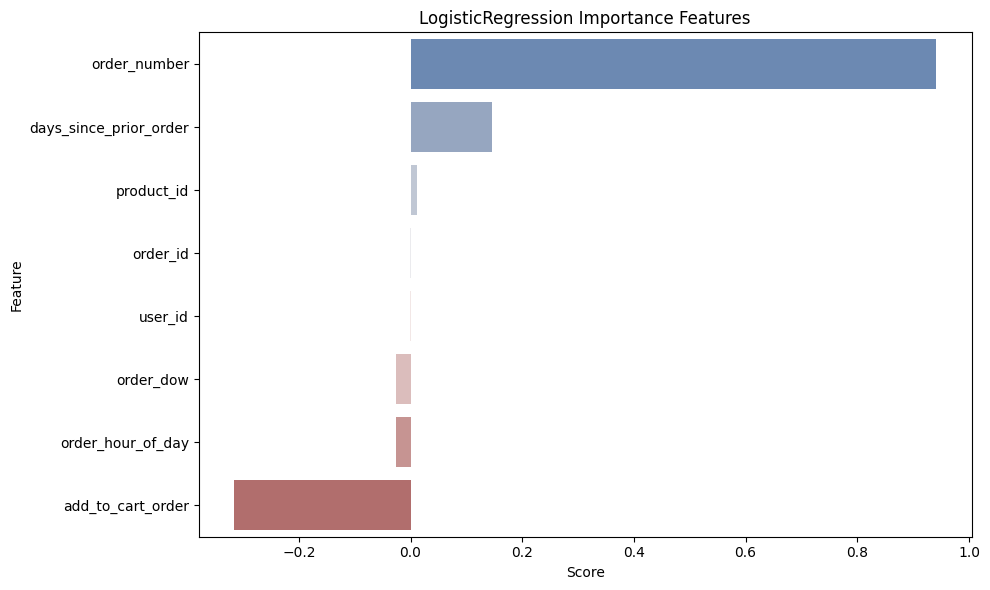

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Feature", data=feature_map.sort_values(by="Score", ascending=False), palette='vlag', hue='Feature')
plt.title('LogisticRegression Importance Features')
plt.tight_layout()
plt.show()

##### DecisionTreeClassifier

In [32]:
def get_hypermarameter_for_dtc():
    # Find DecisionTree Hyperparameter
    depth_list = np.arange(3, 7).tolist()

    # Modeling
    save_depth = []
    acc_score_list = []
    f1_score_list = []

    cnt = 0
    for depth in depth_list:
        print(f">>> {cnt} <<<")
        cnt += 1
        print(f'Max Depth : {depth}')
        # 'gini' > 'entropy log_loss', 'best' > 'random' 
        model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=depth, random_state=model_random_state)
        model.fit(X_prior, y_prior)

        # Train Acc
        y_pre_train = model.predict(X_train)
        cm_train = confusion_matrix(y_train, y_pre_train)
        accuracy = accuracy_score(y_train, y_pre_train)
        f1 = f1_score(y_train, y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print(f"Train Acc : {accuracy}")
        print(f"Train F1-Score : {f1}")
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")

        save_depth.append(depth)
        acc_score_list.append(accuracy)
        f1_score_list.append(f1)

    max_f1_score_index = np.argmax(f1_score_list)
    print(save_depth[max_f1_score_index])
    print(f1_score_list[max_f1_score_index])
    
    return save_depth[max_f1_score_index]

>>> 0 <<<
Max Depth : 3
Train Confusion Matrix
[[ 89626 466167]
 [ 60256 768568]]
Train Acc : 0.619806054670714
Train F1-Score : 0.7448955905791886
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Max Depth : 4
Train Confusion Matrix
[[143419 412374]
 [ 81293 747531]]
Train Acc : 0.6434631381818944
Train F1-Score : 0.7517675862322116
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Max Depth : 5
Train Confusion Matrix
[[198224 357569]
 [126432 702392]]
Train Acc : 0.6504441300374039
Train F1-Score : 0.7437500827251381
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 3 <<<
Max Depth : 6
Train Confusion Matrix
[[128136 427657]
 [ 68584 760240]]
Train Acc : 0.6416041403507251
Train F1-

In [ ]:
max_depth=get_hypermarameter_for_dtc()

In [35]:
model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=max_depth, random_state=model_random_state)
model.fit(X_prior, y_prior)
y_pred_train = model.predict(X_train)

logger.info("accuracy_score:", accuracy_score(y_train, y_pred_train))
logger.info("f1_score:", f1_score(y_train, y_pred_train))
logger.info(classification_report(y_train, y_pred_train))

accuracy_score: 0.6416041403507251
f1_score: 0.7539367121183347
              precision    recall  f1-score   support

           0       0.65      0.23      0.34    555793
           1       0.64      0.92      0.75    828824

    accuracy                           0.64   1384617
   macro avg       0.65      0.57      0.55   1384617
weighted avg       0.64      0.64      0.59   1384617



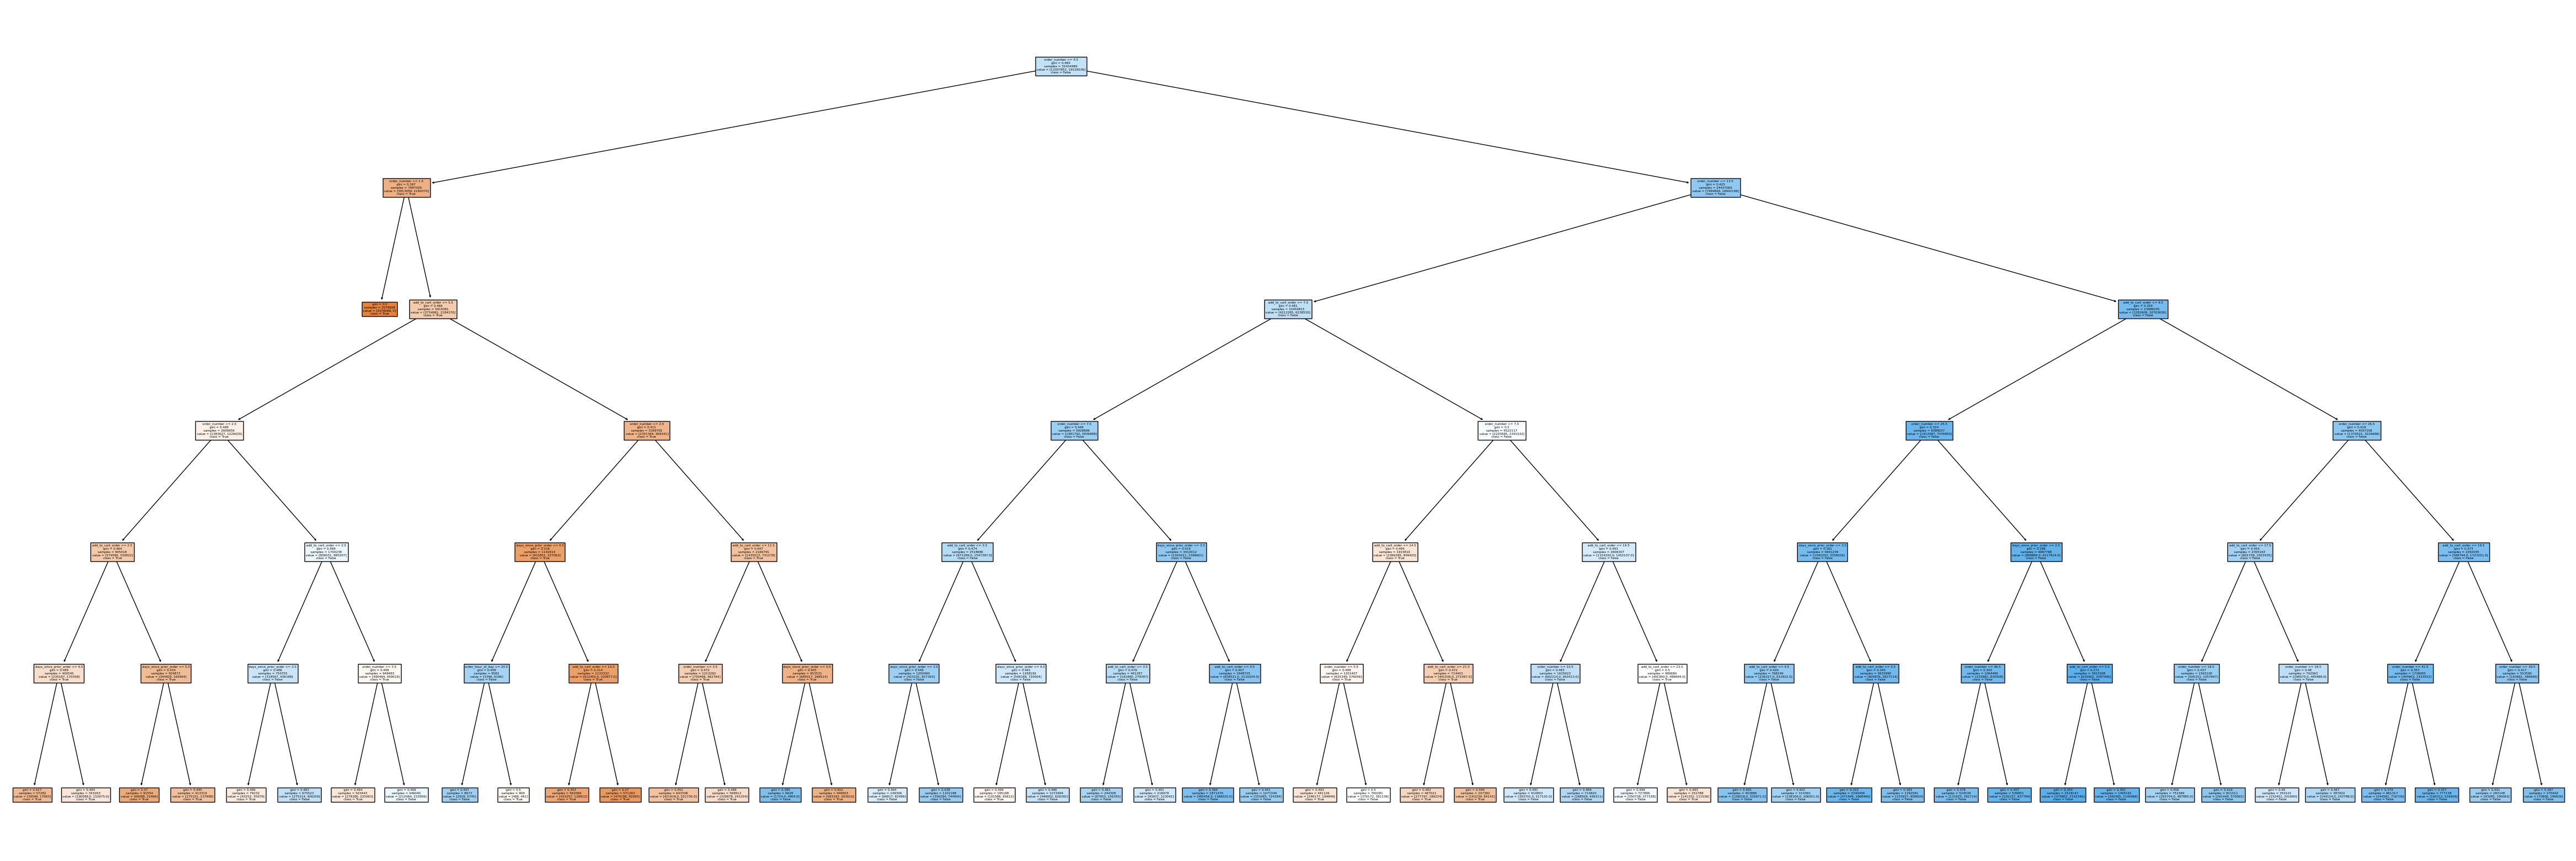

In [39]:
plt.figure(figsize=(60, 20))
tree.plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['True', 'False'])
plt.show()

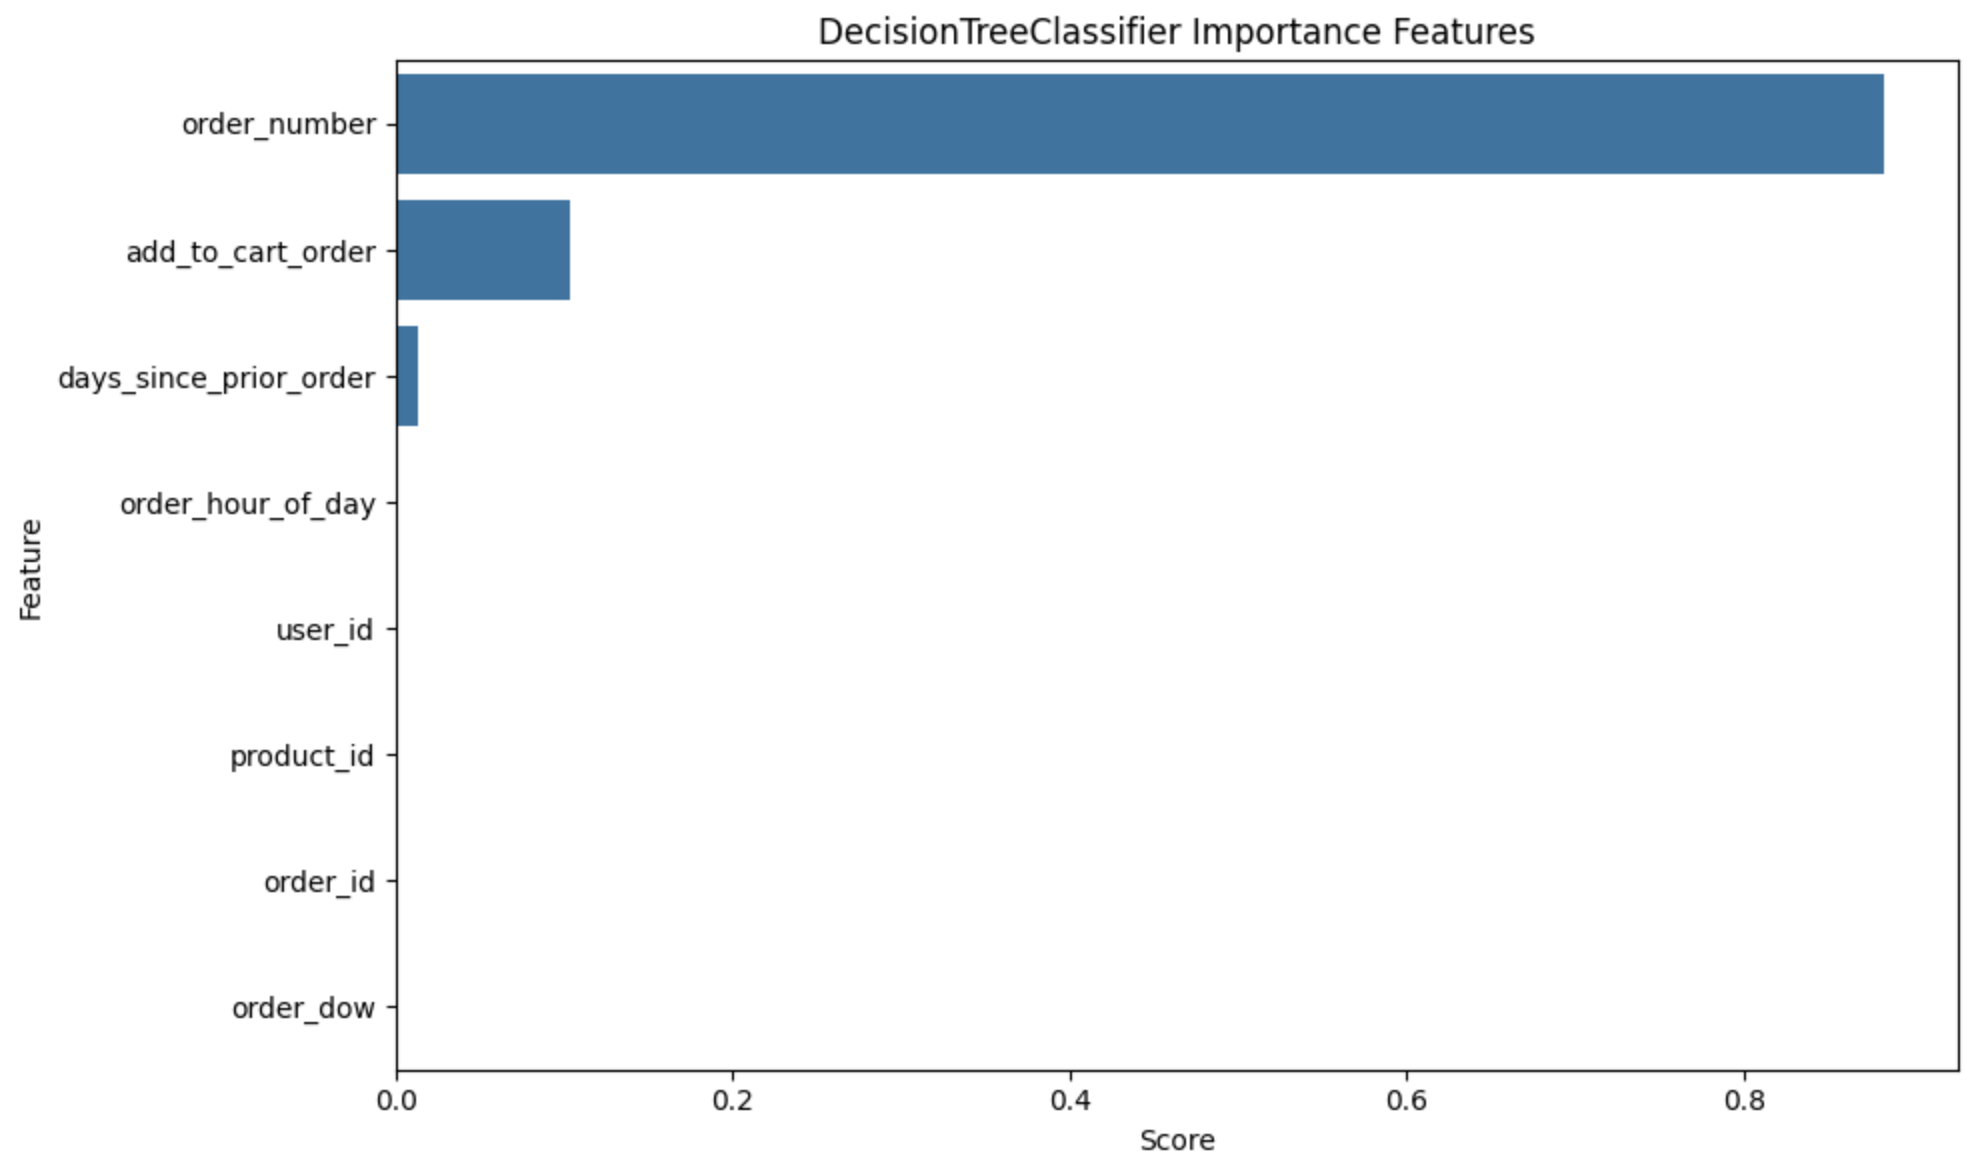

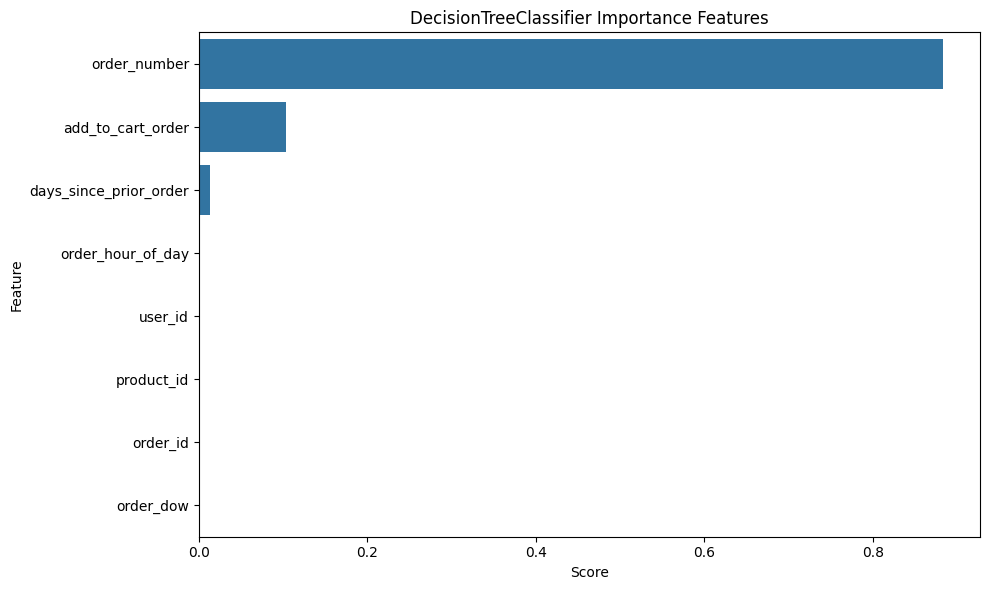

In [40]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns), reverse=True), columns=['Score', 'Feature']).iloc[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Feature", data=feature_map.sort_values(by="Score", ascending=False))
plt.title('DecisionTreeClassifier Importance Features')
plt.tight_layout()
plt.show()

##### RandomForest

In [15]:
def get_hypermarameter_for_rfc():
    # Find RandomForest Hyperparameter
    estimators_list = np.arange(10, 110, 30)

    # Modeling
    save_est = []
    f1_score_list = []

    cnt = 0
    for est in estimators_list:
        print(f">>> {cnt} <<<")
        cnt += 1
        print(f"Number of Estimators : {est}")
        model = RandomForestClassifier(n_estimators=est, criterion='gini', max_depth=6, random_state=model_random_state)
        model.fit(X_prior, y_prior)

        # Train Acc
        y_pre_train = model.predict(X_train)
        cm_train = confusion_matrix(y_train, y_pre_train)
        accuracy = accuracy_score(y_train, y_pre_train)
        f1 = f1_score(y_train, y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print(f"Train Acc : {accuracy}")
        print(f"Train F1-Score : {f1}")
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")

        save_est.append(est)
        f1_score_list.append(f1)

    max_f1_score_index = np.argmax(f1_score_list)
    print(save_est[max_f1_score_index])    
    print(f1_score_list[max_f1_score_index])
    
    return save_est[max_f1_score_index]

In [16]:
best_est = get_hypermarameter_for_rfc()

>>> 0 <<<
Number of Estimators : 10
Train Confusion Matrix
[[120434 435359]
 [ 61523 767301]]
Train Acc : 0.6411411964463819
Train F1-Score : 0.7554093460741015
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 40
Train Confusion Matrix
[[130034 425759]
 [ 66017 762807]]
Train Acc : 0.6448288588107758
Train F1-Score : 0.7562315665290301
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 70
Train Confusion Matrix
[[129025 426768]
 [ 65089 763735]]
Train Acc : 0.6447703588790258
Train F1-Score : 0.7564252842655004
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 3 <<<
Number of Estimators : 100
Train Confusion Matrix
[[129351 426442]
 [ 65753

In [19]:
model = RandomForestClassifier(n_estimators=best_est, criterion='gini', max_depth=6, random_state=model_random_state)
model.fit(X_prior, y_prior)
y_pred_train = model.predict(X_train)

logger.info(f"accuracy_score : {accuracy_score(y_train, y_pred_train)}")
logger.info(f"f1_score : {f1_score(y_train, y_pred_train)}")
logger.info(classification_report(y_train, y_pred_train))

2024-06-09 23:46:46,932 - root - INFO - accuracy_score : 0.6447703588790258
2024-06-09 23:46:47,226 - root - INFO - f1_score : 0.7564252842655004
2024-06-09 23:46:48,568 - root - INFO -               precision    recall  f1-score   support

           0       0.66      0.23      0.34    555793
           1       0.64      0.92      0.76    828824

    accuracy                           0.64   1384617
   macro avg       0.65      0.58      0.55   1384617
weighted avg       0.65      0.64      0.59   1384617



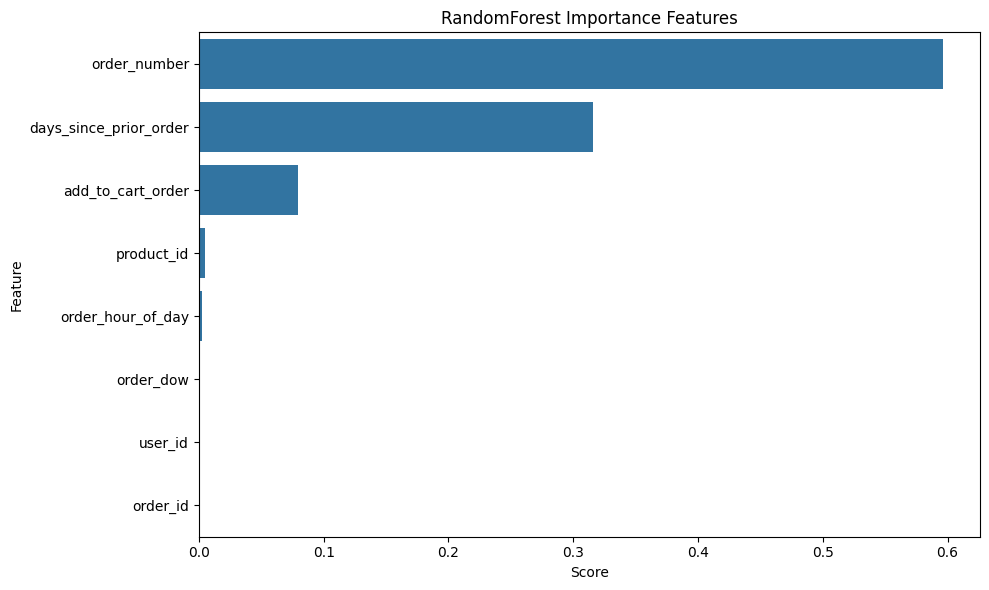

In [21]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns), reverse=True), columns=['Score', 'Feature']).iloc[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Feature", data=feature_map.sort_values(by="Score", ascending=False))
plt.title('RandomForest Importance Features')
plt.tight_layout()
plt.show()

##### XGBoost

In [ ]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5, 6, 7]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n_tree = []
save_l_rate = []
save_m_depth = []
save_L1_norm = []
f1_score_list = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:
                
                print(f">>> {cnt} <<<")
                cnt +=1
                print(f"n_estimators : {n}, learning_rate : {l}, max_depth : {m}, reg_alpha : {L1}")
                model = XGBClassifier(n_estimators=n, learning_rate=l, 
                                      max_depth=m, reg_alpha=L1, objective='binary:logistic', random_state=model_random_state)
                model.fit(X_prior_scaled, y_prior)
                
                # Train Acc
                y_pre_train = model.predict(X_train_scaled)
                cm_train = confusion_matrix(y_train, y_pre_train)
                f1 = f1_score(y_train, y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print(f"Train Acc : {accuracy_score(y_train, y_pre_train)}")
                print(f"Train F1-Score : {f1}")

                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n_tree.append(n)
                save_l_rate.append(l)
                save_m_depth.append(m)
                save_L1_norm.append(L1)
                f1_score_list.append(f1)

max_f1_score_index = np.argmax(f1_score_list)
print(f"n_estimators: {save_n_tree[max_f1_score_index]}")
print(f"learning_rate: {save_l_rate[max_f1_score_index]}")
print(f"max_depth: {save_m_depth[max_f1_score_index]}")
print(f"reg_alpha: {save_L1_norm[max_f1_score_index]}")
print(f"f1_score: {f1_score_list[max_f1_score_index]}")


>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[ 77754 478039]
 [ 36726 792098]]
Train Acc : 0.6282257115144477
Train F1-Score : 0.7547524703889211
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[ 77754 478039]
 [ 36726 792098]]
Train Acc : 0.6282257115144477
Train F1-Score : 0.7547524703889211
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[ 77754 478039]
 [ 36726 792098]]
Train Acc : 0.6282257115144477
Train F1-Score : 0.7547524703889211
-----------------------------------------------------------------------
-------------------------

In [ ]:
model = XGBClassifier(n_estimators=5, learning_rate=0.1, 
                      max_depth=6, reg_alpha=0.1, objective='binary:logistic', random_state=model_random_state)
model.fit(X_prior_scaled, y_prior)
y_pred_train = model.predict(X_train_scaled)

print(f"accuracy_score : {accuracy_score(y_train, y_pred_train)}")
print(f"f1_score : {f1_score(y_train, y_pred_train)}")
print(classification_report(y_train, y_pred_train))

accuracy_score : 0.6282018782089198
f1_score : 0.7553778590442592
              precision    recall  f1-score   support

           0       0.69      0.13      0.23    555793
           1       0.62      0.96      0.76    828824

    accuracy                           0.63   1384617
   macro avg       0.66      0.55      0.49   1384617
weighted avg       0.65      0.63      0.54   1384617



##### LightGBM

In [ ]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5, 6, 7]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n_tree = []
save_l_rate = []
save_m_depth = []
save_L1_norm = []
f1_score_list = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:
                
                print(f">>> {cnt} <<<")
                cnt +=1
                print(f"n_estimators : {n}, learning_rate : {l}, max_depth : {m}, reg_alpha : {L1}")
                model = LGBMClassifier(n_estimators=n, learning_rate=l, 
                                       max_depth=m, reg_alpha=L1, n_jobs=-1, objective='cross_entropy', random_state=model_random_state)
                model.fit(X_prior_scaled, y_prior)
                
                # Train Acc
                y_pre_train = model.predict(X_train_scaled)
                cm_train = confusion_matrix(y_train, y_pre_train)
                f1 = f1_score(y_train, y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print(f"Train Acc : {accuracy_score(y_train, y_pre_train)}")
                print(f"Train F1-Score : {f1}")

                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n_tree.append(n)
                save_l_rate.append(l)
                save_m_depth.append(m)
                save_L1_norm.append(L1)
                f1_score_list.append(f1)

max_f1_score_index = np.argmax(f1_score_list)
print(f"n_estimators: {save_n_tree[max_f1_score_index]}")
print(f"learning_rate: {save_l_rate[max_f1_score_index]}")
print(f"max_depth: {save_m_depth[max_f1_score_index]}")
print(f"reg_alpha: {save_L1_norm[max_f1_score_index]}")
print(f"f1_score: {f1_score_list[max_f1_score_index]}")


>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 32434489.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.780195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 32434489, number of used features: 8
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.589697 -> initscore = 0.362715
[LightGBM] [Info] Start training from score 0.362715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

#### 각 분류모델 별 f1 score & feature importance

1. LogisticRegression
   - f1 score
      - 0.7189861819815352
   - feature importance
      - order_number, days_since_prior_order, product_id
2. DecisionTreeClassifier
   - f1 score
      - 0.7539367121183347
   - feature importance
      - order_number, add_to_cart_order, days_since_prior_order
3. RandomForestClassifier
   - f1 score
      - 0.7564252842655004
   - feature importance
      - order_number, days_since_prior_order, add_to_cart_order, product_id, order_hour_of_day
4. XGBoostClassifier
   - f1 score
      - 0.7553778590442592
5. LightGBM
   - f1 score
      - 0.7553475673656455